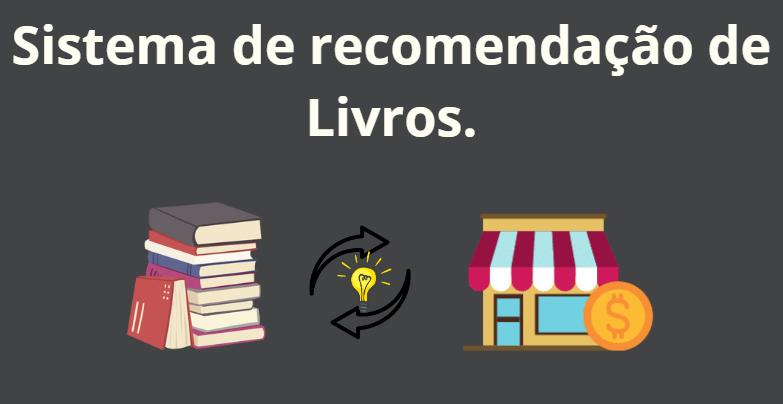

Neste notebook, iremos realizar um sistema de recomendação de Livros, isto é, no nosso 'e-commerce' cliente que realizam a compra de um livro receberam indicações de outros livros. Com isto, visamos aumentar as vendas do site e também o nível de satisfação do cliente, pois estes, poderão conhecer outros livros semelhantes ao que comprou.

# Problemática:

Permitir que os clientes recebam recomendações semelhantes a compra (ou pesquisa) feita, sem que essa recomendação seja feita de forma aleatória, ou recomende livros mal avaliados aos clientes.


# Como será feito:

Utilizaremos aprendizado de máquina não supervisionado, e o algoritmo K-NN, um algoritmo clássico de classificação, que utiliza a informação dos K elementos mais próximos ao que foi selecionado para gerar novas indicações.  Evintando assim, que o sistema recomende elementos aleatórios ao que o cliente selecionou. Além disso, utilizaremos um filtro de avaliação, então selecionaremos da nossa base os livros com a maior quantidade de avaliações, evitando assim que o sistema recomende um produto pouco avaliado, ou com média baixa de avaliação.

# Importaçao das Bibliotecas e Dados

In [ ]:
#Modelagem de dados:
import pandas as pd
import numpy as np
import zipfile

#Visualização de dados:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Avisos:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#Ajustes
#Ajustes no Pandas:
pd.set_option('display.max.rows', 100)
pd.set_option('display.max.columns', 100)

#Ajustes no MatplotLib para tamanho de gráficos:

plt.rcParams['figure.figsize']=(15,6)
plt.style.use('seaborn-darkgrid')

In [ ]:
#Montando nosso drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Extraindo nossos dados utilizando a biblioteca  ---> zipfile <---

# zipfile.ZipFile('/content/drive/MyDrive/arquivos_curso_spark/Dados_Recomendacao+-+Livro.zip','r').extractall('/content/drive/MyDrive/arquivos_curso_spark')

In [ ]:
#Puxando os arquivos:
dados_livros = pd.read_csv('/content/drive/MyDrive/arquivos_curso_spark/Dados_Recomendacao - Livro/Books.csv')
dados_avaliacao = pd.read_csv('/content/drive/MyDrive/arquivos_curso_spark/Dados_Recomendacao - Livro/Ratings.csv')
dados_users = pd.read_csv('/content/drive/MyDrive/arquivos_curso_spark/Dados_Recomendacao - Livro/Users.csv')


In [ ]:
#Verificando a quantidade de dados em cada arquivo:

dados_livros.shape, dados_avaliacao.shape,dados_users.shape

In [ ]:
#Conhecendo os dados:

dados_livros.head()

# Modelagem dos Dados

In [ ]:
dados_livros.info()

In [ ]:
dados_avaliacao.head()

In [ ]:
dados_avaliacao.info()

In [ ]:
dados_users.head()

In [ ]:
dados_users.info()

In [ ]:
#Unificando dados:

dados_cruzados = dados_livros.merge(dados_avaliacao, how ='inner', on='ISBN')

In [ ]:
dados_cruzados.head()

In [ ]:
dados_cruzados = dados_cruzados.merge(dados_users, how='inner', on='User-ID')

In [ ]:
dados_cruzados.info()

In [ ]:
#pd.to_numeric(dados_cruzados['Year-Of-Publication'])

In [ ]:
#Encontrando a linha que sinalizou o erro:
dados_cruzados.iloc[287500]

In [ ]:
#Encontrando a coluna e substituindo por vazio:
dados_cruzados.iloc[287500,3]=''

In [ ]:
dados_cruzados.iloc[467962,3] = ''

In [ ]:
dados_cruzados.iloc[352361,3] = ''

In [ ]:
dados_cruzados.iloc[469216,3] = ''

In [ ]:
pd.to_numeric(dados_cruzados['Year-Of-Publication'])

In [ ]:
dados_cruzados['Year-Of-Publication'] = dados_cruzados['Year-Of-Publication'].astype(str)


In [ ]:
dados_cruzados['Location'].tail(5)

In [ ]:
#Vamos extrair o País da coluna Laocation

#Criando a função:
def extrair_pais(Regiao):
  #Incluindo a informação
  registro = Regiao

  #Pedindo para separar por , que é o separador original
  registro = Regiao.split(',')
  #Pedindo para pegar o último item que é justamente o país
  fracao = registro[-1].upper()
  #Retornando o resultado
  return fracao

#Aplicando a função em pandas e criando a coluna:
dados_cruzados['Pais'] = dados_cruzados['Location'].apply(extrair_pais)

In [ ]:
dados_cruzados.head()

In [ ]:
#Verificando os campos nulos:
dados_cruzados.isnull().sum()

In [ ]:
#Renomeando as colunas:

dados_cruzados.rename(
    columns = {
        'Book-Title':'Titulo',
        'Book-Author':'Autor',
        'Year-Of-Publication':'Ano_Publicacao',
        'Publisher':'Editora',
        'User-ID':'Id_Cliente',
        'Book-Rating':'Avaliacao',
        'Location':'Localizacao',
        'Age':'Idade',

     }, inplace = True
)

In [ ]:
dados_cruzados.head()

# Visualização de Dados:

In [ ]:
#Filtrando valores menores que zero ou iguais a zero
dados_cruzados = dados_cruzados.loc[dados_cruzados['Avaliacao']>0]

#Verificando a existencia de nulos:
dados_cruzados.isnull().sum(), dados_cruzados.shape

In [ ]:
dados_cruzados['Avaliacao'].describe()

In [ ]:
#Analise gráfica:

plt.title('Analisando a avaliação')
sns.boxplot(data=dados_cruzados, x = 'Avaliacao');

Segundo a avaliação acima, podemos verificar que a maioria das avaliações ficaram concentradas em nosso primeiro quartil, que está entre 7 e 9 de avaliação.

In [ ]:
#Analisando os títulos mais bem avaliados:

analise = dados_cruzados.groupby( by=['Titulo']).agg(
    Quantidade = ('Titulo','count'),
    Media      = ('Avaliacao','mean'),
    Max        = ('Avaliacao','max'),
    Min        = ('Avaliacao','min'),
    Mediana    = ('Avaliacao','median')
)

analise.head()

In [ ]:
#Verificando livros que tiveram mais avaliaçãos:

analise.sort_values('Quantidade', ascending=False).head()

In [ ]:
#Verificando livros que tiveram melhores notas:

analise.sort_values(['Mediana','Quantidade'], ascending=False).head()

In [ ]:
#Analisando Qtd x Avaliacao:

px.scatter(
    #Dados
    data_frame=analise,

    #Parametros
    x='Quantidade',y='Media',

    #Titulo
    title='Media x Quantidade - Titulos',
)

In [ ]:
analise.corr()

In [ ]:
analise['Quantidade'].describe()

In [ ]:
def classificacao_quantidade(Quantidade):

  #Agrupar a quantidade:

  if int(Quantidade) <= 5:
    return '1-5 Avaliações.'

  elif int(Quantidade) <= 10:
    return '6-10 Avaliações.'

  elif int(Quantidade) <=50:
    return '11-50Avaliações.'

  elif int(Quantidade) <=100:
    return '51-100 Avaliações.'

  else:
    return 'Maior que 101 Avaliações.'


porcentagem_avaliacoes = analise['Quantidade'].apply(classificacao_quantidade).value_counts(normalize=True)


#Transformar em um DataFrame
porcentagem_avaliacoes = pd.DataFrame(porcentagem_avaliacoes).reset_index()

In [ ]:
px.pie(
    data_frame = porcentagem_avaliacoes,
    names = 'index', values = 'Quantidade',
    title = 'Divisão das quantidades',
    hole = 0.6

)

Com base no gráfico acima, conseguimos observar que existem uma grande quantidade de livros que não obtiveram um bom volume de avaliações. Sendo ineficaz para o objetivo que desejamos alcançar. Para o nosso sistema de avaliações vamos utilizar apenas dados com mais de 50 avaliações.

In [ ]:
#Verificando

porcentagem_avaliacoes

In [ ]:
dados_cruzados['Ano_Publicacao'] = dados_cruzados['Ano_Publicacao'].astype(str)


In [ ]:
#Anos de publicaçaõ

analise_ano = dados_cruzados['Ano_Publicacao'].value_counts().sort_index().reset_index()

analise_ano.head()

In [ ]:
#Por Autor

dados_cruzados.groupby(by='Autor').agg(
    Quantidade = ('Avaliacao','count'),
    Media = ('Avaliacao','mean'),
).sort_values('Quantidade',ascending=False).head(10)

In [ ]:
#Região:

dados_cruzados['Pais'].value_counts(normalize=True).head(10) * 100

In [ ]:
#Região: Concentração das avaliações.

dados_cruzados['Pais'].value_counts(normalize=True).cumsum().head(10) * 100

Podemos verificar que 84% das nossas avaliações estão concentradas nos países: USA, CANADA, REINO UNIDO, GERMANY.

In [ ]:
#Idade

plt.title('Analise de Idades')
sns.boxplot(data=dados_cruzados, x='Idade');

Conseguimos observar que provavelmente existem muitos erros na tabulação de idade, no entanto como idade não é uma informação tão relevante no nosso sistema de recomendação. Podemos descarta essa informação.

# Construção do Modelo:

In [ ]:
#Ajustar (Avaliação dos Livros ---> Tab_Cruzada)

#Na tabela analise, temos o título como um index, para criar uma tabela final com os dados da tabela analise e os dados da tabela dados_cruzados,
#...vamos precisar transformar o titulo em uma coluna.



In [ ]:
#Criando umn index
analise.reset_index()

In [ ]:
#Para minha analise iremos precisar apenas da informação das colunhas index, titulo e quantidade:

avaliacoes = analise.reset_index().iloc[:, 0:2]
avaliacoes.head()

In [ ]:
#Após esse tratamento, agora sim podemos criar uma tabela com os dados unificados:

tab_final = dados_cruzados.merge(avaliacoes, how ='inner', on = 'Titulo')

tab_final.head()

In [ ]:
#Filtrar apenas os dados que possuem dados acima de 50 avaliações:

livros_avaliados= tab_final.loc[tab_final['Quantidade']>=50]


#Verificando:

livros_avaliados.shape

In [ ]:
#Verificando se temos informações duplicadas:

livros_avaliados.duplicated().sum()

In [ ]:
#Gerar a Matriz:
matriz = livros_avaliados.pivot_table(values = 'Avaliacao', index = 'Titulo', columns = 'Id_Cliente')

#Retirando os valores NaN
matriz.fillna(0, inplace = True)

#Verificar:
matriz.head()

In [ ]:
#Transformação para vetores, transformando nosso dataframe em uma matriz esparsa.

from scipy.sparse import csc_matrix

In [ ]:
matriz_sparse = csc_matrix(matriz)

matriz_sparse

In [ ]:
#Criar o modelo

#Treinar o modelo: Escolhemos um 'número de vizinhos ímpar, conforme o recomendado na literatura".

from sklearn.neighbors import NearestNeighbors

modelo = NearestNeighbors(
    #Quantidade de vizinhos. -- Quantidade de recomentações.
    n_neighbors=5,
    #Algoritmo
    algorithm='brute',
    #metrica de distancia
    metric='minkowski'
)

modelo.fit(matriz_sparse)

# Testando o Algoritmo:

#Livro IT - A COISA:

In [ ]:
#Procurando um livro especifico:

for Posicao, Titulo in enumerate(matriz.index):

  if 'It' in Titulo:
    print(Posicao, Titulo)

In [ ]:
#Procurando outro livro para testar
#tab_final.loc[tab_final['Titulo']=='It']

In [ ]:
#Fazendo as redomendações.

#Escolher um livro que será avaliado:
#253 - Livro It a coisa - Stephen King

selecionar_livro = matriz.iloc[253, :].values.reshape(1, -1)
selecionar_livro

In [ ]:
Distancia, Recomendacao = modelo.kneighbors(selecionar_livro)


for loop in range(len(Recomendacao)):

  print(matriz.index[Recomendacao[loop]])

In [ ]:
Recomendacao

Pedimos para o nosso algoritmo recomendar livros com base nos usuários que compraram o livro It a coisa de Stephen King, e ele recomendou 4 outros livros com genero parecido, inclusive um outro livro do Stephen King chamado 'Cujo'.

#Livro Harry Potter:

In [ ]:
#213 - Um livro do Harry Potter:

selecionar_livro = matriz.iloc[213, :].values.reshape(1, -1)
selecionar_livro

In [ ]:
Distancia, Recomendacao = modelo.kneighbors(selecionar_livro)


for loop in range(len(Recomendacao)):

  print(matriz.index[Recomendacao[loop]])

Mais um teste, um cliente que comprou um livro do Harry Potter, recebeu como recomendação outros livros do Harry Potter.

In [ ]:
# Filtrando o link da capa do Harry poter
Link = dados_cruzados.loc[ dados_cruzados['Titulo'] == 'Harry Potter and the Chamber of Secrets (Book 2)' ].head(1)['Image-URL-L'].values[0]

#Recomendação Final com Imagens dos livros:

In [ ]:
from IPython.display import Image

Link = dados_cruzados.loc[dados_cruzados['Titulo'] == 'Harry Potter and the Chamber of Secrets (Book 2)'].head(1)['Image-URL-L'].values[0]

Image(url=Link)


In [ ]:
# Lista para receber os links das recomendações
Lista_URL = []

# Loop nas recomendações
for Loop in range( len(Recomendacao) ):

  # Filtro na matriz
  Selecao_Loop = ( matriz.index[ Recomendacao[Loop] ] )

  # Atribuindo a Lista
  Lista_URL = Selecao_Loop


# Filtrando o link das recomendações
Link_Recomendao_01 = dados_cruzados.loc[ dados_cruzados['Titulo'] == Lista_URL[1] ].head(1)['Image-URL-L'].values[0]
Link_Recomendao_02 = dados_cruzados.loc[ dados_cruzados['Titulo'] == Lista_URL[2] ].head(1)['Image-URL-L'].values[0]
Link_Recomendao_03 = dados_cruzados.loc[ dados_cruzados['Titulo'] == Lista_URL[3] ].head(1)['Image-URL-L'].values[0]
Link_Recomendao_04 = dados_cruzados.loc[ dados_cruzados['Titulo'] == Lista_URL[4] ].head(1)['Image-URL-L'].values[0]

In [ ]:
Image(url=Link_Recomendao_01)
Image(url=Link_Recomendao_02)
Image(url=Link_Recomendao_03)
Image(url=Link_Recomendao_04)

In [ ]:
from IPython.display import Image, display

# Lista de URLs de imagem
Lista_URL = [Link_Recomendao_01, Link_Recomendao_02, Link_Recomendao_03, Link_Recomendao_04]

# Títulos para cada imagem
Titulos = ['Recomendação 1', 'Recomendação 2', 'Recomendação 3', 'Recomendação 4']

# Exibir as imagens lado a lado com seus títulos
for titulo, url in zip(Titulos, Lista_URL):
    display(Image(url=url, width=200))
    print(titulo)




#Conclusão:

Verificamos que após o cliente selecionar o Livro IT - A coisa, o mesmo recebeu as indicações de livros do mesmo gênero, inclusive do mesmo autor. A mesma coisa aconteceu com a seleção de Harry Potter, em que as indicações foram dos outros volumes dos livros do Harry Potter, mostrando assim, a capacidade de classificação do algoritmo.